In [52]:
import geopandas as gpd
from geopandas import GeoDataFrame
import networkx as nx
import pandas as pd
import contextily as ctx
import pathlib
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, LineString

In [31]:
import queue

In [396]:
random_color = lambda: np.random.random(3)

SiteNumber                                                       09054.A
Type                                                              AIRPORT
LocationID                                                           '1B9
Region                                                                      ANE
geometry                     POINT (-71.19777777777779 42.00083333333333)
index                                                                  39

SiteNumber                                                           09304.02A
Type                                                                    AIRPORT
LocationID                                                                 'CEF
Region                                                                      ANE
geometry                           POINT (-72.53478430555555 42.19401497222222)
index                                                                  55

SiteNumber                                                       13434.1*A
Type                                                               AIRPORT
LocationID                                                            '8B2
Region                                                                 ANE
geometry                      POINT (-71.54674869444445 44.26406408333333)
index                                                                  153

In [44]:
game_grid = gpd.read_file('game_grid_2021.geojson')
game_grid = game_grid.drop_duplicates(subset=['MGRS'])

In [45]:
game_grid = game_grid.reset_index().drop(['index'], axis=1)
game_grid

,EASTING,NORTHING,kmSQ_ID,GZD,Shape_Leng,MGRS,MGRS_10km,transport_score,geometry
0,596000mE,4984000mN,WQ,18T,400000.000000,18TWQ9684,18TWQ98,1,"POLYGON ((-73.76921 45.00282, -73.78190 45.002..."
1,597000mE,4984000mN,WQ,18T,400000.000000,18TWQ9784,18TWQ98,1,"POLYGON ((-73.75653 45.00268, -73.76921 45.002..."
2,598000mE,4984000mN,WQ,18T,400000.000000,18TWQ9884,18TWQ98,1,"POLYGON ((-73.74384 45.00254, -73.75653 45.002..."
3,599000mE,4984000mN,WQ,18T,400000.000000,18TWQ9984,18TWQ98,1,"POLYGON ((-73.73116 45.00240, -73.74384 45.002..."
4,579000mE,4983000mN,WQ,18T,400000.000000,18TWQ7983,18TWQ78,1,"POLYGON ((-73.98504 44.99594, -73.99773 44.996..."
...,...,...,...,...,...,...,...,...,...
196817,282000mE,4558000mN,BF,19T,0.041828,19TBF8258,19TBF85,1,"POLYGON ((-71.58574 41.14431, -71.59765 41.144..."
196818,283000mE,4558000mN,BF,19T,0.041828,19TBF8358,19TBF85,1,"POLYGON ((-71.57384 41.14458, -71.58574 41.144..."
196819,284000mE,4558000mN,BF,19T,0.041828,19TBF8458,19TBF85,1,"POLYGON ((-71.56193 41.14484, -71.57384 41.144..."
196820,285000mE,4558000mN,BF,19T,0.041828,19TBF8558,19TBF85,1,"POLYGON ((-71.55003 41.14511, -71.56193 41.144..."


In [46]:
game_grid_copy = game_grid.copy()
game_grid_copy['geometry'] = game_grid.to_crs('epsg:3857').buffer(10).to_crs('epsg:4326')
game_grid_copy

,EASTING,NORTHING,kmSQ_ID,GZD,Shape_Leng,MGRS,MGRS_10km,transport_score,geometry
0,596000mE,4984000mN,WQ,18T,400000.000000,18TWQ9684,18TWQ98,1,"POLYGON ((-73.76912 45.00281, -73.76913 45.002..."
1,597000mE,4984000mN,WQ,18T,400000.000000,18TWQ9784,18TWQ98,1,"POLYGON ((-73.75644 45.00268, -73.75644 45.002..."
2,598000mE,4984000mN,WQ,18T,400000.000000,18TWQ9884,18TWQ98,1,"POLYGON ((-73.74375 45.00254, -73.74375 45.002..."
3,599000mE,4984000mN,WQ,18T,400000.000000,18TWQ9984,18TWQ98,1,"POLYGON ((-73.73107 45.00240, -73.73107 45.002..."
4,579000mE,4983000mN,WQ,18T,400000.000000,18TWQ7983,18TWQ78,1,"POLYGON ((-73.98495 44.99594, -73.98495 44.995..."
...,...,...,...,...,...,...,...,...,...
196817,282000mE,4558000mN,BF,19T,0.041828,19TBF8258,19TBF85,1,"POLYGON ((-71.58565 41.14431, -71.58565 41.144..."
196818,283000mE,4558000mN,BF,19T,0.041828,19TBF8358,19TBF85,1,"POLYGON ((-71.57375 41.14458, -71.57375 41.144..."
196819,284000mE,4558000mN,BF,19T,0.041828,19TBF8458,19TBF85,1,"POLYGON ((-71.56184 41.14484, -71.56184 41.144..."
196820,285000mE,4558000mN,BF,19T,0.041828,19TBF8558,19TBF85,1,"POLYGON ((-71.54994 41.14511, -71.54994 41.145..."


In [50]:
edges = gpd.sjoin(game_grid, game_grid_copy, how='inner', op='intersects')
edges

,EASTING_left,NORTHING_left,kmSQ_ID_left,GZD_left,Shape_Leng_left,MGRS_left,MGRS_10km_left,transport_score_left,geometry,index_right,EASTING_right,NORTHING_right,kmSQ_ID_right,GZD_right,Shape_Leng_right,MGRS_right,MGRS_10km_right,transport_score_right
0,596000mE,4984000mN,WQ,18T,400000.000000,18TWQ9684,18TWQ98,1,"POLYGON ((-73.76921 45.00282, -73.78190 45.002...",22,597000mE,4983000mN,WQ,18T,400000.000000,18TWQ9783,18TWQ98,1
1,597000mE,4984000mN,WQ,18T,400000.000000,18TWQ9784,18TWQ98,1,"POLYGON ((-73.75653 45.00268, -73.76921 45.002...",22,597000mE,4983000mN,WQ,18T,400000.000000,18TWQ9783,18TWQ98,1
2,598000mE,4984000mN,WQ,18T,400000.000000,18TWQ9884,18TWQ98,1,"POLYGON ((-73.74384 45.00254, -73.75653 45.002...",22,597000mE,4983000mN,WQ,18T,400000.000000,18TWQ9783,18TWQ98,1
21,596000mE,4983000mN,WQ,18T,400000.000000,18TWQ9683,18TWQ98,1,"POLYGON ((-73.76941 44.99382, -73.78209 44.993...",22,597000mE,4983000mN,WQ,18T,400000.000000,18TWQ9783,18TWQ98,1
22,597000mE,4983000mN,WQ,18T,400000.000000,18TWQ9783,18TWQ98,1,"POLYGON ((-73.75672 44.99368, -73.76941 44.993...",22,597000mE,4983000mN,WQ,18T,400000.000000,18TWQ9783,18TWQ98,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196821,286000mE,4558000mN,BF,19T,0.041829,19TBF8658,19TBF85,1,"POLYGON ((-71.53813 41.14537, -71.55003 41.145...",196820,285000mE,4558000mN,BF,19T,0.041828,19TBF8558,19TBF85,1
196814,285000mE,4559000mN,BF,19T,0.041832,19TBF8559,19TBF85,2,"POLYGON ((-71.55038 41.15411, -71.56229 41.153...",196821,286000mE,4558000mN,BF,19T,0.041829,19TBF8658,19TBF85,1
196815,286000mE,4559000mN,BF,19T,0.041832,19TBF8659,19TBF85,1,"POLYGON ((-71.53847 41.15437, -71.55038 41.154...",196821,286000mE,4558000mN,BF,19T,0.041829,19TBF8658,19TBF85,1
196820,285000mE,4558000mN,BF,19T,0.041828,19TBF8558,19TBF85,1,"POLYGON ((-71.55003 41.14511, -71.56193 41.144...",196821,286000mE,4558000mN,BF,19T,0.041829,19TBF8658,19TBF85,1


In [53]:
graph = nx.Graph()
for i, r in game_grid.iterrows():
    graph.add_node(r['MGRS'])

In [54]:
count = 0
for i, r in edges.iterrows():
    if(count % 100000 == 0):
        print(count)
    
    node1 = r['MGRS_left']
    node2 = r['MGRS_right']

    edge_weight = 20. / (r['transport_score_left'] + r['transport_score_right'])
    if(node1 != node2):
        graph.add_edge(node1, node2, weight=edge_weight)
    count += 1

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000


In [13]:
dist = GeoDataFrame(columns = ['geometry'])
dist['geometry'] = [Point(-71.19777777777779, 42.00083333333333), Point(-72.53478430555555, 42.19401497222222), Point(-71.54674869444445, 44.26406408333333)]
dist = dist.set_crs('epsg:4326')

In [21]:
dist = gpd.sjoin(dist, game_grid, how='inner', op='within')
dist

,geometry,index_right,EASTING,NORTHING,kmSQ_ID,GZD,Shape_Leng,MGRS,MGRS_10km,transport_score
0,POINT (-71.19778 42.00083),111183,317000mE,4652000mN,CG,19T,0.042148,19TCG1752,19TCG15,10
0,POINT (-71.19778 42.00083),111184,317000mE,4652000mN,CG,19T,0.042148,19TCG1752,19TCG15,10
1,POINT (-72.53478 42.19401),96926,703000mE,4674000mN,YM,18T,297265.528077,18TYM0374,18TYM07,1
2,POINT (-71.54675 44.26406),77303,296000mE,4904000mN,BK,19T,0.043044,19TBK9604,19TBK90,10


In [24]:
dist

,geometry,index_right,EASTING,NORTHING,kmSQ_ID,GZD,Shape_Leng,MGRS,MGRS_10km,transport_score
0,POINT (-71.19778 42.00083),111183,317000mE,4652000mN,CG,19T,0.042148,19TCG1752,19TCG15,10
1,POINT (-72.53478 42.19401),96926,703000mE,4674000mN,YM,18T,297265.528077,18TYM0374,18TYM07,1
2,POINT (-71.54675 44.26406),77303,296000mE,4904000mN,BK,19T,0.043044,19TBK9604,19TBK90,10


In [311]:
hospitals_url = 'Hospitals.csv'
hospitals_df = pd.read_csv(hospitals_url)

hospitals_df = hospitals_df.fillna('')
hospitals_df = hospitals_df.loc[(hospitals_df['X']>= -74.0062751207002) & (hospitals_df['X']<= -66.93832921282291) & (hospitals_df['Y'] >= 40.995556258214776) & (hospitals_df['Y'] <= 47.46624330268622)]
hospitals_df = hospitals_df.reset_index().drop(['index'], axis=1)

loc_gdf = GeoDataFrame()
loc_gdf['geometry'] = None
for i, r in hospitals_df.iterrows():
    h_point = Point(r['X'], r['Y'])
    loc_gdf.loc[i, 'geometry'] = h_point
loc_gdf = loc_gdf.set_crs(epsg=4326)

joined_loc = gpd.sjoin(loc_gdf, game_grid, how='inner', op='within')
joined_loc = joined_loc.reset_index().drop(['index'], axis=1)

In [142]:
hosp = joined_loc.copy()

hosp["vis"] = 0
hosp["incoming"] = [set() for i in range (hosp.shape[0])]
hosp["supplies"] = 5000
hosp

,geometry,index_right,EASTING,NORTHING,kmSQ_ID,GZD,Shape_Leng,MGRS,MGRS_10km,transport_score,vis,incoming,supplies
0,POINT (-72.74062 41.70169),121303,687000mE,4619000mN,XM,18T,400000.000000,18TXM8719,18TXM81,3,0,{},5000
1,POINT (-71.05394 42.06302),110181,330000mE,4658000mN,CG,19T,0.042172,19TCG3058,19TCG35,3,0,{},5000
2,POINT (-72.68244 42.34953),91933,690000mE,4691000mN,XM,18T,400000.000000,18TXM9091,18TXM99,7,0,{},5000
3,POINT (-72.68240 42.34960),91933,690000mE,4691000mN,XM,18T,400000.000000,18TXM9091,18TXM99,7,0,{},5000
4,POINT (-71.17170 42.27463),106511,320000mE,4682000mN,CG,19T,0.042251,19TCG2082,19TCG28,7,0,{},5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,POINT (-72.00956 44.44579),36867,737000mE,4925000mN,YQ,18T,275703.837111,18TYQ3725,18TYQ32,10,0,{},5000
341,POINT (-71.48081 44.90445),73302,304000mE,4975000mN,CK,19T,0.043321,19TCK0475,19TCK07,7,0,{},5000
342,POINT (-71.55434 44.48623),75409,296000mE,4929000mN,BK,19T,0.043140,19TBK9629,19TBK92,3,0,{},5000
343,POINT (-73.80366 42.65597),12855,598000mE,4723000mN,WN,18T,400000.000000,18TWN9823,18TWN92,4,0,{},5000


In [264]:
n = hosp.shape[0]
t = 50

In [90]:
ind = dict()

In [91]:
for i, r in hosp.iterrows():
    ind[r["MGRS"]] = i

In [259]:
ind['19TCG1752'] = n
ind['18TYM0374'] = n+1
ind['19TBK9604'] = n+2

In [284]:
sp_mat = np.load("sp_mat-2.npy")

In [257]:
sp_mat

array([[  0.        , 163.30316742,  78.05882353, ..., 144.76470588,
         69.58327947, 327.70588235],
       [163.30316742,   0.        , 166.50790386, ...,  18.53846154,
        149.61753932, 272.74789916],
       [ 78.05882353, 166.50790386,   0.        , ..., 147.96944232,
         30.58568882, 258.        ],
       ...,
       [144.76470588,  18.53846154, 147.96944232, ...,   0.        ,
        131.07907778, 270.06722689],
       [ 69.58327947, 149.61753932,  30.58568882, ..., 131.07907778,
          0.        , 280.23274764],
       [327.70588235, 272.74789916, 258.        , ..., 270.06722689,
        280.23274764,   0.        ]])

In [273]:
for i in range (sp_mat.shape[0]):
    for j in range (sp_mat.shape[1]):
        if i != j and sp_mat[i][j] == 0:
            print (i, j)

2 3
3 2
8 9
9 8
34 35
34 36
34 37
34 38
35 34
35 36
35 37
35 38
36 34
36 35
36 37
36 38
37 34
37 35
37 36
37 38
38 34
38 35
38 36
38 37
39 40
39 41
40 39
40 41
41 39
41 40
45 46
46 45
65 66
66 65
69 70
69 71
70 69
70 71
71 69
71 70
76 77
77 76
83 84
84 83
85 86
86 85
107 108
108 107
163 164
164 163
173 174
173 175
174 173
174 175
175 173
175 174
201 202
201 203
202 201
202 203
203 201
203 202
236 237
237 236
243 244
244 243
249 250
250 249
293 294
294 293


In [285]:
add_to_pq = []
for i in range (t):
    print (truck_loc[i])
    loc = truck_loc[i]
    
    min_dist = np.inf
    min_loc = None
    min_j = None
    for j in range (n):
        if j == ind[loc]:
            continue
            
        if sp_mat[j][ind[loc]] < min_dist:
            min_dist = sp_mat[j][ind[loc]]
            min_loc = hosp.loc[j]["MGRS"]
            min_j = j
    
    if min_dist != np.inf:
        add_to_pq.append([min_dist, min_loc, i, min_j])
        print (loc)

19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
19TCG1752
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
18TYM0374
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604
19TBK9604


In [286]:
add_to_pq

[[6.0, '19TCG1457', 0, 131],
 [6.0, '19TCG1457', 1, 131],
 [6.0, '19TCG1457', 2, 131],
 [6.0, '19TCG1457', 3, 131],
 [6.0, '19TCG1457', 4, 131],
 [6.0, '19TCG1457', 5, 131],
 [6.0, '19TCG1457', 6, 131],
 [6.0, '19TCG1457', 7, 131],
 [6.0, '19TCG1457', 8, 131],
 [6.0, '19TCG1457', 9, 131],
 [6.0, '19TCG1457', 10, 131],
 [6.0, '19TCG1457', 11, 131],
 [6.0, '19TCG1457', 12, 131],
 [6.0, '19TCG1457', 13, 131],
 [6.0, '19TCG1457', 14, 131],
 [6.0, '19TCG1457', 15, 131],
 [15.199780611545318, '18TYM0870', 16, 123],
 [15.199780611545318, '18TYM0870', 17, 123],
 [15.199780611545318, '18TYM0870', 18, 123],
 [15.199780611545318, '18TYM0870', 19, 123],
 [15.199780611545318, '18TYM0870', 20, 123],
 [15.199780611545318, '18TYM0870', 21, 123],
 [15.199780611545318, '18TYM0870', 22, 123],
 [15.199780611545318, '18TYM0870', 23, 123],
 [15.199780611545318, '18TYM0870', 24, 123],
 [15.199780611545318, '18TYM0870', 25, 123],
 [15.199780611545318, '18TYM0870', 26, 123],
 [15.199780611545318, '18TYM0870', 

In [223]:
pq = queue.PriorityQueue()

for i in range (t):
    loc = truck_loc[i]
    sp = nx.single_source_dijkstra_path_length(graph, loc)
    
    min_dist = np.inf
    min_loc = None
    min_j = None
    for j in range (n):
        try:
            d = sp[hosp.loc[j]["MGRS"]]
        except:
            continue
        if sp[hosp.loc[j]["MGRS"]] < min_dist:
            min_dist = sp[hosp.loc[j]["MGRS"]]
            min_loc = hosp.loc[j]["MGRS"]
            min_j = j
    
    if min_dist != np.inf:
        pq.put([min_dist, min_loc, i, min_j])
        hosp.loc[min_j]["incoming"].add(i)

In [160]:
while pq.empty() == False:
    arr = pq.get()
    print (arr)

[6.0, '19TCG1457', 0, 131]
[6.0, '19TCG1457', 1, 131]
[6.0, '19TCG1457', 2, 131]
[6.0, '19TCG1457', 3, 131]
[6.0, '19TCG1457', 4, 131]
[6.0, '19TCG1457', 5, 131]
[15.199780611545318, '18TYM0870', 6, 123]
[15.199780611545318, '18TYM0870', 7, 123]
[15.199780611545318, '18TYM0870', 8, 123]
[15.199780611545318, '18TYM0870', 9, 123]
[15.199780611545318, '18TYM0870', 10, 123]
[15.199780611545318, '18TYM0870', 11, 123]
[15.199780611545318, '18TYM0870', 12, 123]
[26.319974143503558, '19TBK9629', 13, 342]
[26.319974143503558, '19TBK9629', 14, 342]
[26.319974143503558, '19TBK9629', 15, 342]
[26.319974143503558, '19TBK9629', 16, 342]
[26.319974143503558, '19TBK9629', 17, 342]
[26.319974143503558, '19TBK9629', 18, 342]
[26.319974143503558, '19TBK9629', 19, 342]


In [377]:
truck_loc = []
truck_supp = []
truck_timetaken = [] #in minutes
truck_path = []

max_time = 7200
for i in range (16):
    truck_loc.append("19TCG1752")
    truck_path.append(["19TCG1752"])
for i in range (17):
    truck_loc.append("18TYM0374")
    truck_path.append(["18TYM0374"])
for i in range (17):
    truck_loc.append("19TBK9604")
    truck_path.append(["19TBK9604"])
    
for i in range (50):
    truck_supp.append(10000)
    truck_timetaken.append(0)

In [378]:
#hosp = joined_loc.copy()

hosp["vis"] = 0
hosp["incoming"] = [set() for i in range (hosp.shape[0])]
hosp["supplies"] = 300 * (np.random.randint(8, size=hosp.shape[0]) + 1)

In [379]:
pq = queue.PriorityQueue()

for item in add_to_pq:
    pq.put(item)
    hosp.loc[item[3]]["incoming"].add(item[2])

In [380]:
while pq.empty() == False:
    arr = pq.get()
    time = arr[0]
    loc = arr[1]
    truck = arr[2]
    hosp_ind = arr[3]
    
    if hosp.loc[hosp_ind]["vis"] == 1:
        continue
    
    print (arr)

    #update this truck's path
    
    hosp.loc[hosp_ind, "vis"] = 1
    truck_loc[truck] = loc
    truck_timetaken[truck] += time
    truck_supp[truck] -= hosp.loc[hosp_ind]["supplies"]
    truck_timetaken[truck] += ((hosp.loc[hosp_ind]["supplies"] + 1999) // 2000) * 20
    truck_path[truck].append(loc)
    
        
    # reroute all trucks that had added this hospital
    for i in hosp.loc[hosp_ind]["incoming"]:
        #print (i)
        tloc = truck_loc[i]
    
        min_dist = np.inf
        min_loc = None
        min_j = None
        for j in range (n):
            
            if hosp.loc[j]["vis"] == 0 and sp_mat[ind[tloc]][j] < min_dist:
                if truck_timetaken[i] + sp_mat[ind[tloc]][j] + ((hosp.loc[j]["supplies"] + 1999) // 2000) * 20 < max_time:
                    if truck_supp[i] >= hosp.loc[j]["supplies"]:
                        if loc == "18TXM9091" and i == 32:
                            print ("*")
                        
                        min_dist = sp_mat[ind[tloc]][j]
                        min_loc = hosp.loc[j]["MGRS"]
                        min_j = j

        #print (min_dist)
        if min_dist != np.inf:
            pq.put([min_dist, min_loc, i, min_j])
            #print ([min_dist, min_loc, i, min_j])
            #print (str(i) + " rerouted")
            hosp.loc[min_j]["incoming"].add(i)
        else:
            print (i)

[6.0, '19TCG1457', 0, 131]
[13.033613445378151, '19TCG1145', 1, 68]
[7.605042016806722, '19TCG0444', 1, 299]
[6.605042016806723, '19TCG0238', 1, 182]
[2.1764705882352944, '19TCG0036', 1, 184]
[2.5384615384615383, '19TCG0235', 1, 186]
[5.538461538461538, '19TBG9734', 1, 76]
[0.0, '19TBG9734', 1, 77]
[2.0, '19TBG9536', 1, 187]
[5.0, '19TBG9931', 1, 173]
1
[15.199780611545318, '18TYM0870', 16, 123]
[8.934065934065934, '18TYM0266', 16, 25]
[3.605042016806723, '18TXM9966', 16, 328]
[1.4285714285714286, '18TXM9865', 16, 212]
[1.8181818181818181, '18TXM9866', 16, 47]
[4.994652406417112, '18TXM9570', 16, 53]
[4.0, '18TXM9574', 16, 211]
[13.176470588235293, '18TXM8565', 16, 213]
[16.176470588235293, '19TCG1873', 0, 19]
[3.6363636363636362, '19TCG1675', 0, 27]
[7.46218487394958, '19TCG1881', 0, 317]
[3.5384615384615383, '19TCG2082', 0, 4]
[6.818181818181818, '19TCG2285', 0, 308]
[8.214285714285715, '19TCG2587', 0, 300]
[1.8181818181818181, '19TCG2688', 0, 83]
0
[16.748545572074985, '19TCG2542', 

In [393]:
all_pts = pd.concat([joined_loc, dist], axis=0)
all_pts = all_pts.reset_index(drop=True)
all_pts

,geometry,index_right,EASTING,NORTHING,kmSQ_ID,GZD,Shape_Leng,MGRS,MGRS_10km,transport_score
0,POINT (-72.74062 41.70169),96795,687000mE,4619000mN,XM,18T,400000.000000,18TXM8719,18TXM81,3
1,POINT (-71.05394 42.06302),88814,330000mE,4658000mN,CG,19T,0.042172,19TCG3058,19TCG35,3
2,POINT (-72.68244 42.34953),76300,690000mE,4691000mN,XM,18T,400000.000000,18TXM9091,18TXM99,7
3,POINT (-72.68240 42.34960),76300,690000mE,4691000mN,XM,18T,400000.000000,18TXM9091,18TXM99,7
4,POINT (-71.17170 42.27463),86237,320000mE,4682000mN,CG,19T,0.042251,19TCG2082,19TCG28,7
...,...,...,...,...,...,...,...,...,...,...
343,POINT (-73.80366 42.65597),11172,598000mE,4723000mN,WN,18T,400000.000000,18TWN9823,18TWN92,4
344,POINT (-72.27333 43.67619),48497,719000mE,4839000mN,YP,18T,283010.602629,18TYP1939,18TYP13,2
345,POINT (-71.19778 42.00083),111183,317000mE,4652000mN,CG,19T,0.042148,19TCG1752,19TCG15,10
346,POINT (-72.53478 42.19401),96926,703000mE,4674000mN,YM,18T,297265.528077,18TYM0374,18TYM07,1


In [398]:
def plot_route(routes):
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    for i, route in enumerate(routes):
        if len(route) == 1:
            continue
        linestr = LineString([all_pts.loc[i, 'geometry'] for i in route])
        c = random_color()
        x, y = linestr.xy
        ax.plot(x, y, color=c)
    plt.show()

In [388]:
routes = truck_path.copy()
for i in range (t):
    for j in range (len(routes[i])):
        routes[i][j] = ind[routes[i][j]]

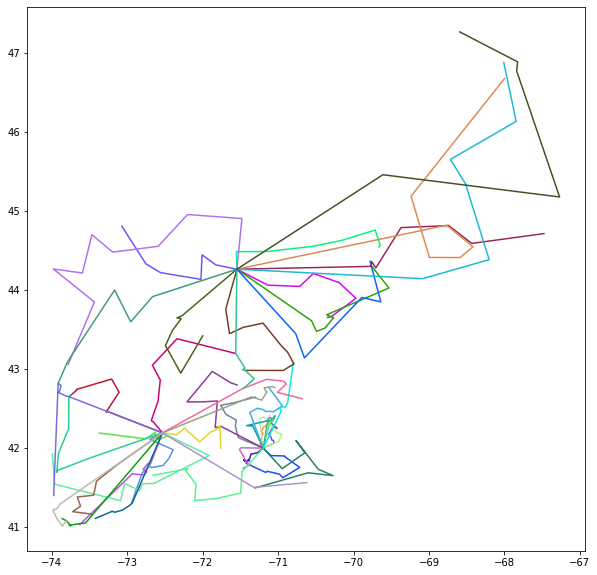

In [399]:
plot_route(routes)

In [381]:
hosp["vis"].sum()

342

In [383]:
truck_timetaken

[233.6641299876594,
 224.49709114414998,
 370.4725274725275,
 306.3046953046953,
 265.23555855908796,
 251.00840336134453,
 327.98624904507255,
 246.97784568372805,
 248.89075630252103,
 428.7065287653523,
 483.5919374742905,
 209.81512605042016,
 239.55233002291828,
 326.5517129928895,
 459.13901458019103,
 328.03819709702066,
 312.71138665256314,
 360.6477052359405,
 373.0112044817927,
 460.257957728546,
 411.47806768395003,
 596.4454499748618,
 425.9714860303096,
 416.31006248653307,
 339.2219349278173,
 459.83731954320194,
 499.514407161466,
 376.0466200466199,
 429.72301554654496,
 365.71544142132376,
 317.396113690231,
 356.15750915750925,
 0,
 434.7800043094161,
 422.49206349206344,
 422.77053012347125,
 506.85620915032683,
 858.8650467179882,
 462.2182001005531,
 606.4690570867042,
 354.5576776165012,
 518.6231415643181,
 572.46918767507,
 621.2091503267973,
 898.059182647418,
 937.4575261339967,
 1024.0122230710458,
 0,
 0,
 0]

In [384]:
truck_supp

[100,
 100,
 100,
 100,
 100,
 400,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 400,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 400,
 100,
 400,
 400,
 7600,
 400,
 10000,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 400,
 100,
 100,
 100,
 100,
 100,
 3400,
 10000,
 10000,
 10000]

In [42]:
for i in range (t):
    loc = truck_loc[i]
    
    min_dist = np.inf
    min_loc = None
    for j in range (n):
        if sp_mat[ind[loc]][j] < min_dist:
            min_dist = sp_mat[ind[loc]][j]
            min_loc = joined_loc.loc[j]["MGRS"]
    
    if min_dist != np.inf:
        pq.put([-min_dist, min_loc])

KeyError: '19TCG1752'

In [43]:
ind['19TCG1752']

KeyError: '19TCG1752'